In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime
import sys


In [6]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import rand_score

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.metrics import dtw, dtw_path
from tslearn.barycenters import dtw_barycenter_averaging

In [7]:
df_old = pd.read_csv('data.csv')
df_old[["date"]] = df_old[["date"]].apply(pd.to_datetime)
# df_old = df_old.iloc[:100000]
df_old.head()

,date,id,price,presence,level_0,level_1,level_2,level_3
0,2016-01-04,1,27.500444,True,20.0,2010.0,201010.0,20101010.0
1,2016-01-04,6,0.580261,False,45.0,4510.0,451020.0,45102008.0
2,2016-01-04,7,12.740000,False,45.0,4520.0,452010.0,45201020.0
3,2016-01-04,8,NaN,False,45.0,4530.0,453010.0,45301008.0
4,2016-01-04,9,35.286670,True,20.0,2020.0,202010.0,20201050.0


In [8]:
df = df_old.drop(['level_0', 'level_1', 'level_2', 'level_3'], axis=1)
df.head()

,date,id,price,presence
0,2016-01-04,1,27.500444,True
1,2016-01-04,6,0.580261,False
2,2016-01-04,7,12.740000,False
3,2016-01-04,8,NaN,False
4,2016-01-04,9,35.286670,True


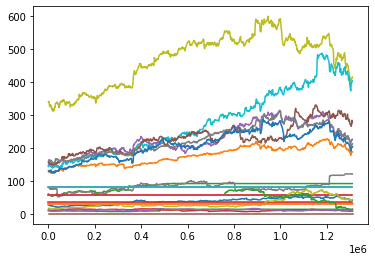

In [9]:
for ID in df_old[df_old.level_3 == 20101010.0].id.unique():
    plt.plot(df[df.id == ID].price)
plt.show()

Перейдём к стартовой кластеризации.

In [30]:
def get_clusterisation(data, k):
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw")
    labels = model.fit_predict(data)

    centroids = model.cluster_centers_
    return labels, centroids

def revert_cluster_dict(cluster_dict):
    reverted_dict = dict()
    for elem in cluster_dict:
        if cluster_dict[elem] in reverted_dict:
            reverted_dict[cluster_dict[elem]] += 1
        else:
            reverted_dict[cluster_dict[elem]] = 1
    return reverted_dict

def revert_cluster_dict_indexes(cluster_dict):
    reverted_dict = dict()
    for elem in cluster_dict:
        if cluster_dict[elem] not in reverted_dict:
            reverted_dict[cluster_dict[elem]] = set()
        reverted_dict[cluster_dict[elem]].add(elem)
    return reverted_dict

def remove_degenerate_clusters(labels_dict, centroids, data):
    reverted_dict = revert_cluster_dict(labels_dict)
 
    clusters_to_remove = list()
    for cluster_number in reverted_dict:
        if reverted_dict[cluster_number] < 10:
            clusters_to_remove.append(cluster_number)
    #print(reverted_dict)
    print("Removing these clusters:", clusters_to_remove)

    for idx in labels_dict:
        if labels_dict[idx] in clusters_to_remove:
            row = data.loc[idx]
            min_dist = float('inf')
            final_label = -1
            for j in range(len(centroids)):
                if j in clusters_to_remove:
                    continue

                cur_dist = dtw(row, centroids[j])
                if cur_dist < min_dist:
                    min_dist = cur_dist
                    final_label = j
            labels_dict[idx] = final_label
    return labels_dict

def split_clusters(labels_dict, data, indexes):
    if data.shape[1] <= 5:
        return labels_dict

    reverted_dict = revert_cluster_dict_indexes(labels_dict)
    cur_max_label = max(reverted_dict) + 1
    current_labels = reverted_dict.keys()

    largest_label = max(reverted_dict, key=reverted_dict.get)

    
    current_ids = list(reverted_dict[largest_label])
    new_data = data.loc[current_ids]
    new_labels, centroids = get_clusterisation(new_data, 2)
    
    zeros_n = new_labels.shape[0] - sum(new_labels)
    ones_n = sum(new_labels)
    proba = min(ones_n, zeros_n) / max(ones_n, zeros_n)

    coin = np.random.binomial(1, proba, 1)[0]
    print(proba)
    if coin:
        print('Splitting')
        print(largest_label, reverted_dict)
        for i in range(len(current_ids)):
            ID = current_ids[i]
            if new_labels[i] == 0:
                labels_dict[ID] = cur_max_label

    if False: # here I evaluate the silhouette score change after the cluster splitting. 
        smallest_label = min(reverted_dict, key=reverted_dict.get)
        largest_ids2 = list(reverted_dict[largest_label]) + [list(reverted_dict[smallest_label])[0]]
        new_data2 = data.loc[largest_ids2]
        print(silhouette_score(new_data2, np.append(new_labels, 3), metric="dtw"))
        print(silhouette_score(new_data2, np.append(np.zeros(new_labels.shape), 3), metric="dtw"))

    return labels_dict


def find_centroids(data, labels_dict):
    reverted_dict = revert_cluster_dict_indexes(labels_dict)
    centroids = list()
    for cluster_id in sorted(reverted_dict.keys()):
        centroids.append(dtw_barycenter_averaging(data.loc[reverted_dict[cluster_id]]))
    return centroids

def add_new_stocks(labels_dict, centroids, data, new_indexes):
    for idx in new_indexes:
        row = data.loc[idx]
        min_dist = float('inf')
        final_label = -1
        for j in range(len(centroids)):    
            cur_dist = dtw(row, centroids[j])
            if cur_dist < min_dist:
                min_dist = cur_dist
                final_label = j
        labels_dict[idx] = final_label
    return labels_dict

def compare_clusterisations(labels1, labels2): # rand_index
    return rand_score(labels1, labels2)

In [31]:
def transform_df(df_init, from_date, to_date):
    df_init = df_init[(from_date < df_init.date) & (df_init.date <= to_date)]
    if df_init.empty:
        return df_init

    df_init = transpose_df(df_init)

    mask1 = df_init.isna()
    mask2 = df_init.shift(periods=1, axis="columns", fill_value=0).isna()
    mask3 = df_init.shift(periods=-1, axis="columns", fill_value=0).isna()
    
    df_init.fillna(1)
    
    column_list = df_init.columns
    for i in range(len(column_list) - 1, 0, -1):
        col_cur = column_list[i]
        col_prev = column_list[i - 1]
        df_init[[col_cur]] = df_init[[col_cur]].div(df_init[col_prev], axis=0) - 1

    df_init = df_init[~mask1 & ~mask2 & ~mask3].fillna(1)

    if df_init.shape[1] == 1:
        return df_init

    return df_init.drop([column_list[0]], axis=1)

def transpose_df(dataframe):
    row_list = list()
    id_list = list()
    date_flag = True
    date_list = list()
    for ID in dataframe.id.unique():
        if date_flag:
            date_flag = False
            date_list = dataframe[dataframe.id == ID].date.tolist()

        row = dataframe[dataframe.id == ID].price

        row_list.append(row.tolist())
        id_list.append(ID)
        
    res_df = pd.DataFrame(row_list, columns=date_list)
    res_df.index = id_list
    return res_df

In [32]:
class Clusterisation:
    def __init__(self, dataframe, initial_to_date, days_delta):
        initial_to_date += datetime.timedelta(days=days_delta)
        self.days_delta = days_delta
        self.df = dataframe
        self.final_df = dataframe
        
        self.initial_to_date = initial_to_date
        self.to_date = initial_to_date
        self.from_date = datetime.datetime(2010, 1, 1)
        
        self.data = transform_df(self.df, self.from_date, self.to_date)
        self.k = 18
        self.new_indexes = set(self.data.index.to_list())
        
        self.id_cluster_date = dict()

    def set_clusterisation(self):
        df_init = self.data
        labels, centroids = get_clusterisation(self.data, self.k)
        
        self.labels_to_dict(labels)    
        self.labels_dict = remove_degenerate_clusters(self.labels_dict, centroids, self.data)
        self.write_results()

    def write_results(self):
        timestamps = self.df[(self.df.date <= self.to_date) & (self.from_date < self.df.date)].date.unique().tolist()
        for timestamp in timestamps:
            if timestamp not in self.id_cluster_date:
                self.id_cluster_date[timestamp] = dict()
            for ID in self.labels_dict:
                self.id_cluster_date[timestamp][ID] = self.labels_dict[ID]

    def progress_clusterisation(self):
        self.from_date = self.to_date
        self.to_date += datetime.timedelta(days=self.days_delta)
        
        self.data = transform_df(self.df, self.from_date, self.to_date)
        
        if self.data.empty:
            return
        
        self.old_indexes = self.new_indexes
        self.new_indexes = set(self.data.index.to_list())
        
        common_indexes = self.old_indexes & self.new_indexes
        gone_indexes = self.old_indexes - self.new_indexes
        new_indexes = self.new_indexes - self.old_indexes
 
        self.remove_gone_labels(gone_indexes) # удаляем ушедшие
        
        self.labels_dict = split_clusters(self.labels_dict, self.data, common_indexes)
        
        #split_clusters(self.labels_dict, self.data, common_indexes)
        
        centroids = find_centroids(self.data, self.labels_dict)
        self.labels_dict = remove_degenerate_clusters(self.labels_dict, centroids, self.data)
        
        centroids = find_centroids(self.data, self.labels_dict)
        self.labels_dict = add_new_stocks(self.labels_dict, centroids, self.data, new_indexes)
        
        self.write_results()
        self.progress_clusterisation()
    
    def labels_to_dict(self, labels):
        self.labels_dict = dict()
        i = 0
        for elem in self.data.index:
            self.labels_dict[elem] = labels[i]
            i += 1

    def dict_to_labels(self):
        self.labels = list()
        for elem in sorted(self.labels_dict.keys()):
            self.labels.append(self.labels_dict[elem])
        self.labels = np.array(self.labels)
    
    def remove_gone_labels(self, gone_indexes):
        for idx in gone_indexes:
            del self.labels_dict[idx]

    def get_cluster_dict(self):
        return self.cluster_dict

    def get_data(self):
        return self.data

    def get_real_clusters(self):
        return self.clusters_to_compare

    def get_labels(self):
        return self.labels

    def get_results(self):
        return self.id_cluster_date

    def set_final_df(self):
        cluster_ids = list()
        for index, row in self.final_df.iterrows():
            timestamp, ID = row['date'], row['id']
            timestamp_num = int(timestamp.timestamp() * 10**9)
            if timestamp_num not in self.id_cluster_date:
                print(timestamp, timestamp_num, )
            cluster_id = self.id_cluster_date[timestamp_num][ID]
            cluster_ids.append(cluster_id)
        self.final_df['cluster_id'] = pd.Series(cluster_ids, index = self.final_df.index)

    def get_final_df(self):
        return self.final_df

In [33]:
work = Clusterisation(df, df.loc[0, 'date'], 30)

In [34]:
df.tail()

,date,id,price,presence
1311635,2018-12-31,6913,19.43000,False
1311636,2018-12-31,6934,NaN,False
1311637,2018-12-31,6948,NaN,False
1311638,2018-12-31,6949,NaN,False
1311639,2018-12-31,6961,0.21375,False


In [35]:
work.set_clusterisation()

Removing these clusters: [12, 3, 7, 8, 15, 16, 6]


In [36]:
work.progress_clusterisation()

0.24489795918367346
Removing these clusters: []
0.05172413793103448
Removing these clusters: []
0.008264462809917356
Removing these clusters: []
0.008264462809917356
Removing these clusters: []
0.14018691588785046
Removing these clusters: []
0.0990990990990991
Removing these clusters: []
0.14018691588785046
Removing these clusters: []
0.008264462809917356
Removing these clusters: []
0.03389830508474576
Splitting
13 {13: {1, 2565, 2574, 5134, 1555, 1044, 3100, 37, 5162, 5168, 4660, 5172, 4662, 5180, 5181, 2633, 5194, 587, 1612, 3151, 3159, 4707, 106, 5742, 4719, 4720, 5743, 115, 4729, 125, 4606, 4234, 3213, 5263, 1683, 3227, 5788, 162, 2724, 5291, 5292, 5300, 4789, 5304, 2235, 5308, 5821, 707, 1224, 2249, 5324, 4312, 732, 3299, 3306, 1259, 5358, 2287, 1776, 754, 5367, 2303, 5375, 5378, 3345, 1299, 3351, 1304, 2328, 5409, 2344, 4904, 5417, 305, 819, 4415, 2371, 4932, 2890, 3919, 2395, 2401, 355, 1381, 4966, 4976, 2929, 2932, 4480, 4481, 4996, 903, 4490, 1421, 4494, 2961, 926, 5023, 2471,

In [37]:
work.set_final_df()
final_dataframe = work.get_final_df()


In [38]:
final_dataframe.to_csv('out.zip', index=False)

KeyboardInterrupt: ignored